# Cross-modal (text and figures) Analysis of a Scientific Corpus from Semantic Scholar

## Overview

**Raul Ortega** (rortega@expertsystem.com)

**Jose Manuel Gomez-Perez** (jmgomez@expertsystem.com)

*Expert System (http://www.expertsystem.com) *


In this notebook we show the application of crossmodal techniques to improve the categorization of scientific papers through content related to figures, using both the textual part (captions) and the visual part (figures, diagrams, images) jointly. To this purpose, we use several CNN models and execute some experiments, illustrating our approach.

## Initialization


The source code of this notebook is available in Github ( https://github.com/rortegaes/crossmodal_models ). We have four scripts:
1.   **data_loading**. To download and access to the corpus available in URL A ZENODO.
2.   **experiments**. To run the experiments.
3.   **models**. To generate the models.
4.   **qualitative**. To generate a qualitative analysis of the results



In [1]:
from crossmodal_models import data_loading
from crossmodal_models import experiments
from crossmodal_models import models
from crossmodal_models import qualitative

from keras.utils.vis_utils import plot_model
import pydot
import cv2
from IPython.display import Image, display
import matplotlib.pyplot as plt

/home/test/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/test/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/test/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/test/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/test/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype s

## Hypothesis

To carry out this research, we designed a set of hypotheses aligned with the experiments we will run later:

* **H1**: **Both a figure and its caption can be categorized automatically based on its content with respect to an arbitrary taxonomy**. 
There are several works, such as García and Gómez-Pérez [1], that runs experiments to categorize a corpus of scientific papers using blocks of text that define the content of an article in a general way, such as the title and the abstract. However, in this work we will try to find out if the information contained in the visual material of an article (its figures) or in blocks of text less descriptive (its captions) allows to categorize scientific publications in the same way.

* **H2**: **The caption of a figure and the figure itself contain complementary knowledge**. 
Following what was described by Both et al. [2], with a corpus of general purpose, the knowledge of each modality is complementary to the others. This can be applied into a scientific environment, as shown in Figures 1 and 2. On one hand, Figure 1 shows how the caption of two very similar figures can make the difference in the task of distinguish the figure's scientific field. On the other hand, Figure 2 shows how visual information is necessary in order to distinguish what field it refers to, since certain words such as "injection" or "cavity" can be interpreted as words from the field of medicine or "locking plate" from the field of engineering, when just looking at the image we can easily distinguish that it is the opposite.

<table><tr><td><img src='https://github.com/rortegaes/crossmodal_models/blob/master/images/Ejemplo-Buen-Caption.png?raw=true'><center>*Figure 1. Example of figures whose captions help to detect the scientific field of the image.*</center></td><td><img src='https://github.com/rortegaes/crossmodal_models/blob/master/images/Ejemplo-Buenas-Figures.png?raw=true'><center>*Figure 2. Example of captions whose figures help to detect the scientific field of the image.*</center></td></tr></table>
 

* **H3**: **There is knowledge transference between models when performing a crosmodal analysis of figure-caption**. 
To carry out this hypotheis, we have to be aligned with the work of Arandjelovicet al. [3], who designed a mixed convolutional neuronal network with a visual and an audio part, and ran an association task between both modalities. The result of this experiment was that both modalities completed the features that they were able to extract thanks to the other, due to the back-propagation of this type of networks, which adjusts its weights based on an output. If we are able to apply this to the scope of this research, specifically to the figure and its caption, it will be possible a transference of knowledge between both modalities.

* **H4**: **The transference of knowledge between modalities helps to improve the categorization of papers**. 
Based on the previous hypothesis, we will check whether this transference between modalities is positive at the time of significantly improving the categorization of papers based on their scientific field.

## Corpus

To carry out the experiments of this research, we took the open corpora of **Semantic Scholar** (http://labs.semanticscholar.org/corpus/) and we selected those papers which have an **available PDF** (for figure and caption extraction) and which are also in **Scigraph** (for scientific field labeling). We did not consider papers that can belong to different categories simultaneously. The workflow related to the corpus filtering is shown in detail in Figure 3.


<center> 
    <img src='https://github.com/rortegaes/crossmodal_models/blob/master/images/workflow-corpus-filtering.png?raw=true'> *Figure 3. Visual representation of the various filters we used to get our corpus from the open Semantic Scholar corpora. This corpus is public and available in Zenodo (URL AL REPOSITORIO DE ZENODO)*
</center>


## Models

We designed three models to evaluate our hypotheses: a textual model, a visual model and a crossmodal model.

### Textual model


We took the work of García and Gómez-Pérez [1] and Yoon Kim [4] to design this convolutional neural network. **The input of this CNN are sequences of 1000 tokens**. There's a layer of embeddings, and three blocks formed by a layer with 128 convolutional filters with ReLU activation, and a max-pooling layer with stride 2. Next, there is a flatten layer followed by two fully connected layers,the first one with ReLU activation and the second one with softmax activation for classification, whose **output will be the field of science** to which the input belongs according to SciGraph.

In [ ]:
num_class = 2
num_words = 157206
textModel = models.generateTextualModel(num_class, num_words)
plot_model(textModel, to_file='./images/textModel.png', show_shapes=True, show_layer_names=True)
display(Image('./images/textModel.png'))

### Visual model

We follow the **VGG-network design style**, alligned with the Arandjelovic et al. [3] work , with an **input of 224x244 colour image**, four blocks of conv+conv+pool layers, a flatten layer and two fully connected layers, one with ReLU activation and the last one with softmax activation, whose **output will be the field of science** to which the input belongs. On one hand, the convolutional layers of this architecture work with 3x3 convolutional filters, where the number of filters is doubled in each block (64, 128, 256 and 512), and each one of them is followed by batch normalization and ReLU activation. The max-pooling layers, on the other hand, are 2x2 with stride 2.

In [ ]:
visualModel = models.generateVisualModel(num_class)
plot_model(visualModel, to_file='./images/visualModel.png', show_shapes=True, show_layer_names=True)
display(Image('./images/visualModel.png'))

### Crossmodal model

For this model, **we concatenate the outputs of the last max-pooling layers of textual and visual CNNs**, as Arandjelovic et al. [3] work shows, and we follow up the architecture with a flatten layer and two fully connected layers, the first one with ReLU activation and the last one with softmax activation, which can lead to **two possible outputs: the figure and the caption correspond or not.**


In [ ]:
crossModel = models.generateCrossModel(num_class,num_words)
plot_model(crossModel, to_file='./images/crossModel.png', show_shapes=True, show_layer_names=True)
display(Image('./images/crossModel.png'))

## Experiments

We designed two categorization experiments, of different granulity, to evaluate each hypothesis:

1. We made a **clustering** of several categories in only two: **Health Sciences** (formed by articles from Medical and Health Sciences and Biological Sciences) and **Technology Sciences** (composed of articles from Mathematical Sciences, Engineering and Information and Computing Sciences). Both clusters have a strong load of figures and conceptually quite apart from each other, so this experiment will help us to know how well our neural networks are capable of discerning between large fields of knowledge

2. The **clustering was undone** and we ran the categorization experiments with articles which belong to **Medical and Health Sciences, Biological Sciences, Mathematical Sciences, Engineering and Information and Computing Sciences**. The number of figures and articles belonging to these categories is remarkably unequal and some of them are conceptually similar to each other, so this experiment will show us how our neural networks behave in a finer grain categorization task than the previous one.

The training of every model used on this research was carried out using cross validation (10-fold), so that it could be checked whether or not there is overfitting in the process. 46,953 articles and 82,396 figures (and captions) were used in each one of the experiments.

### Baseline: Title+Abstract

First, and before running the experiments, we tried to repeat with our data and models the experiment carried out by García and Gómez-Pérez [1] of** categorization of a corpus of scientific articles based on their title and abstract**. Thanks to this baseline, we can check and compare the operation of our textual model with blocks of text that describe the content of the publications more generally than the figures or the subtitles.

#### 2-clusters

In [ ]:
num_papers = 4694
experiments.exp_title_abs("2clusters", num_papers)

#### 5-class

In [ ]:
num_papers = 4694
experiments.exp_title_abs("5class", num_papers)

### Experiment #1: Categorization by figures

With this experiment, we want to evaluate the first part of hypothesis **H1**: can a figure be categorized automatically based on its content?

#### 2-clusters

In [ ]:
num_images = 8239
experiments.exp_figures("2clusters","unimodal", num_images, training=False)

#### 5-class

In [ ]:
num_images = 8239
experiments.exp_figures("5class","unimodal", num_images, training=False)

### Experiment  #2: Categorization by captions

With this experiment, we want to evaluate the second part of hypothesis **H1**: can a figure be categorized automatically based on the content of its caption? 

#### 2-clusters

In [ ]:
num_captions = 8239
experiments.exp_captions("2clusters","unimodal",num_captions,training=False)

#### 5-class

In [ ]:
num_captions = 8239
experiments.exp_captions("5class","unimodal",num_captions,training=False)

### Experiment #3: Figure-caption association

With this experiment, we want to evaluate the hypothesis **H2** and **H3** (complementarity and knowledge transfer between figure and caption models)

In [ ]:
num_images = 26607
experiments.exp_cross(num_images, training=False)

### Experiment #4: Crossmodal quantitative analysis (figure+caption)

In this experiment, **we ran again the experiments #1 and #2, but using the weights generated in the experiment #3**. The result of this experiment will be studied to check if there is an improvement when categorizing an article based on any of the two modalities (Hypothesis **H4**) and qualitatively, analyzing specific cases of improvement and how the weights have acted of the mixed network as opposed to the unimodal processing, so that we can obtain a more exhaustive analysis of how the crosmodal transmission of knowledge works.

#### 2-clusters

In [ ]:
num_images = 8239
experiments.exp_figures("2clusters","crossmodal", num_images)

In [ ]:
num_captions = 8239
experiments.exp_captions("2clusters","crossmodal", num_captions)

#### 5-class

In [ ]:
num_images = 8239
experiments.exp_figures("5class","crossmodal", num_images)

In [ ]:
num_captions = 8239
experiments.exp_captions("5class","crossmodal", num_captions)

### Experiment #5: Crossmodal qualitative analysis (figure+caption)

With this experiment we will examine** specific cases of improvement** and how the weights have acted of the mixed network as opposed to the unimodal processing, so that we can obtain a more exhaustive analysis of how the **crosmodal transmission** of knowledge works. For this purpose, we will generate **heatmaps** to visualize to which sections of this figures the visual neuronal network is paying attention depending on whether it has the weights of the crossmodal analysis or not.

Diferencia de 3958: 31.81348145008087(Uni: 0.49627736; Mix: 0.8144122)
Diferencia de 76: 16.71697199344635(Uni: 0.35463187; Mix: 0.5218016)
Diferencia de 2679: 37.79732882976532(Uni: 0.14172682; Mix: 0.5197001)
Diferencia de 3514: 64.17697668075562(Uni: 0.17044197; Mix: 0.81221175)


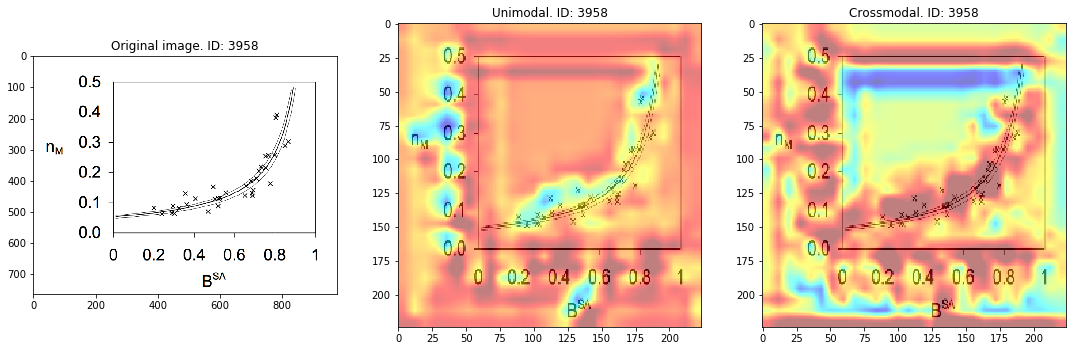

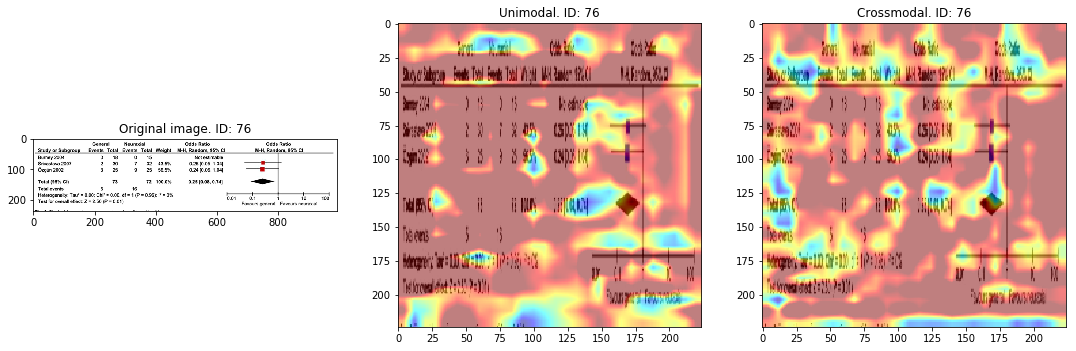

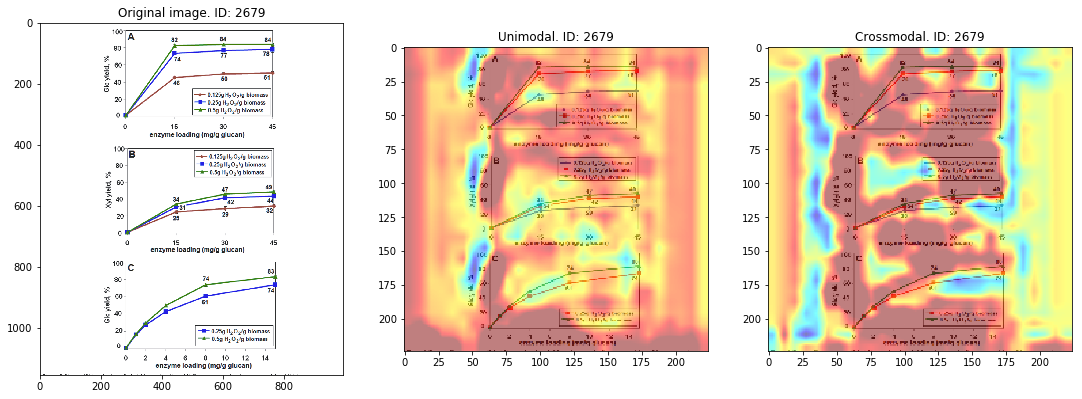

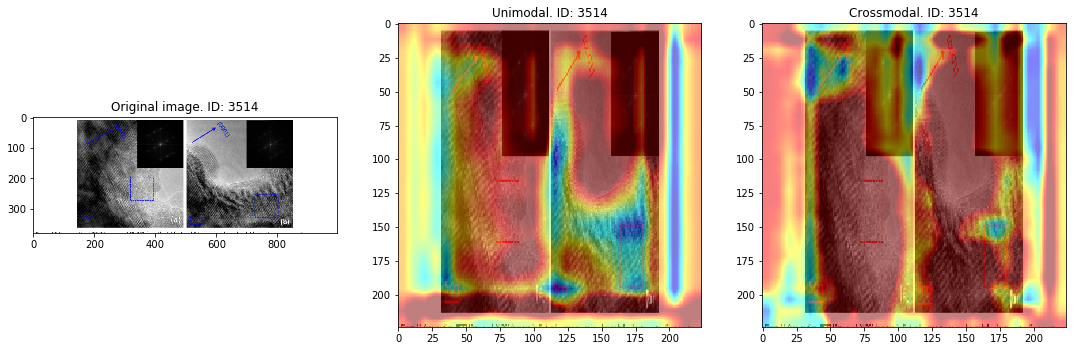

In [2]:
qualitative.getCAM("2clusters")

Diferencia de 2237: 52.611905336380005(Uni: 0.2666455; Mix: 0.79276454)
Diferencia de 4449: 31.88151717185974(Uni: 0.2089166; Mix: 0.5277318)
Diferencia de 3516: 73.89841079711914(Uni: 0.16338356; Mix: 0.90236765)
Diferencia de 1220: 23.437434434890747(Uni: 0.21570584; Mix: 0.4500802)


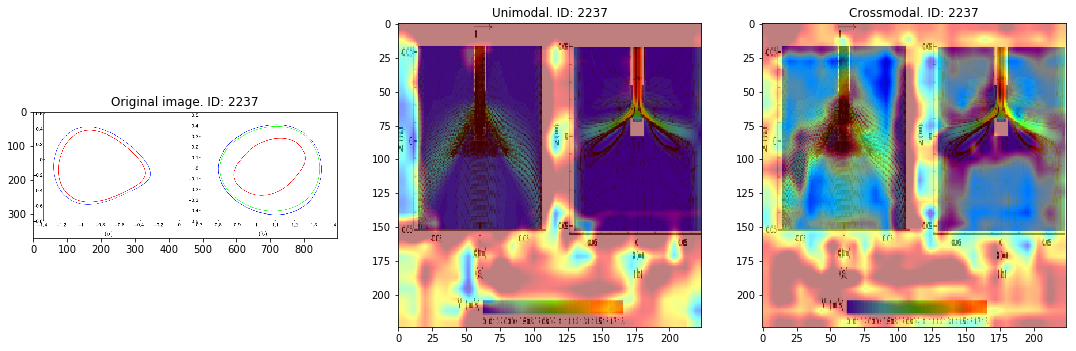

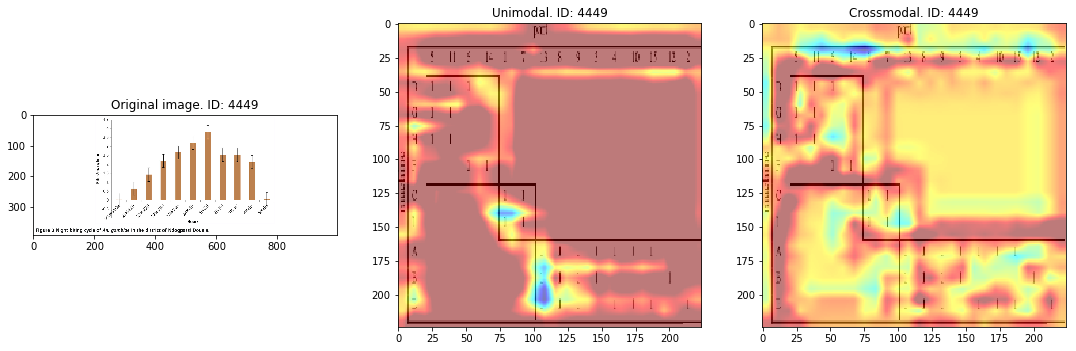

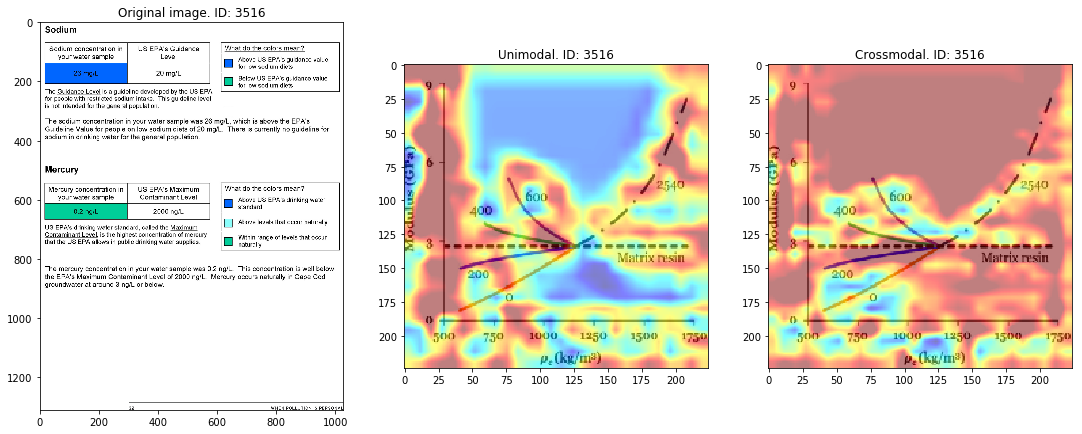

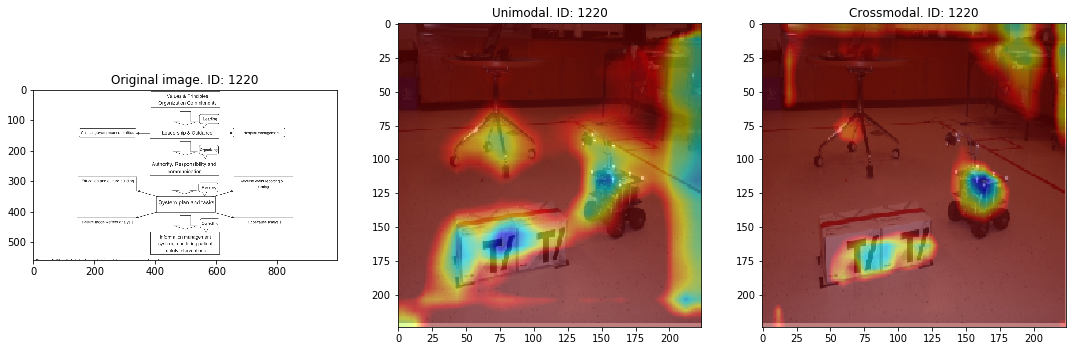

In [3]:
qualitative.getCAM("5class")

## Conclusions


From the results obtained in the experiments above, we can conclude that:

*   **VGG based models** can extract **features of high level** from the figures of a scientific corpus.
*   A figure's **caption** contains enough information to **categorize** it.
*   There is **knowledge transference between modalities** when performing a crosmodal analysis of figure-caption, which **helps to categorize them**.

## References

[1] Andrés García, José Manuel Gómez-Pérez (2018). Not just about size – A Study on the Role of Distributed Word Representations in the Analysis of Scientific Publications: https://arxiv.org/abs/1804.01772

[2] Fabian Both, Steffen Thoma, Achim Rettinger (2017). Cross-modal Knowledge Transfer: Improving the Word Embedding of Apple by Looking at Oranges: http://www.aifb.kit.edu/images/0/00/K_CAP_2017_CrossModalKnowledgeTransfer_PrePub.pdf

[3] Relja Arandjelovic, Andrew Zisserman (2017). Look, Listen and Learn: https://arxiv.org/abs/1705.08168

[4] Yoon Kim (2014). Convolutional Neural Networks for Sentence Classification: https://arxiv.org/abs/1408.5882